In [1]:
import pandas as pd
from pandas import DataFrame as df
import numpy as np
from astropy import cosmology
import matplotlib.pyplot as plt
import getdist as gd
from getdist import MCSamples
import getdist.plots as gdplot
import matplotlib
from scipy.stats import norm
import matplotlib.mlab as mlab
from autogalaxy.util import cosmology_util
from astropy import constants

cosmo = cosmology.Planck15

In [2]:
from autoconf import conf
import autofit as af
import autolens as al
import autolens.plot as aplt
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
import matplotlib.pyplot as plt
from matplotlib import gridspec as gridspec
from matplotlib.colors import SymLogNorm
import re
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS
from autoarray.structures import grids
from autoarray.structures import vector_fields
import getdist as gd
from getdist import MCSamples
import getdist.plots as gdplot

fig_path = '/Users/dgmt59/Documents/Plots/weak_lensing/'

In [3]:
from astropy.io import fits
lens_no = "1430+4105"

data_path = f"/Users/dgmt59/Documents/Data/slacs_weak_lensing/{lens_no}_F814W_drz_sci_clean.shears"
field_image_path = f"/Users/dgmt59/Documents/Data/slacs_weak_lensing/{lens_no}_F814W_drz_sci.fits"
slacs_shu_path = "/Users/dgmt59/PycharmProjects/autolens_slacs_pre_v_1/dataset/slacs_shu/slacs"

weak_shear = fits.open(data_path)
data = weak_shear[1].data
field_image_data  = get_pkg_data_filename(field_image_path)
field_image = fits.getdata(field_image_data, ext=0)

In [4]:
centre_pix = open(f"{slacs_shu_path}{lens_no}/lens_centre_pix.dat").read()
y_pix, x_pix = centre_pix[2:-3].split(',')
centre = np.asarray([float(y_pix), float(x_pix)])

centre_arcsec = open(f"{slacs_shu_path}{lens_no}/lens_centre_arc_sec.dat").read()
y_arc, x_arc = centre_arcsec[2:-3].split(',')
centre_a= np.asarray([float(y_arc), float(x_arc)])

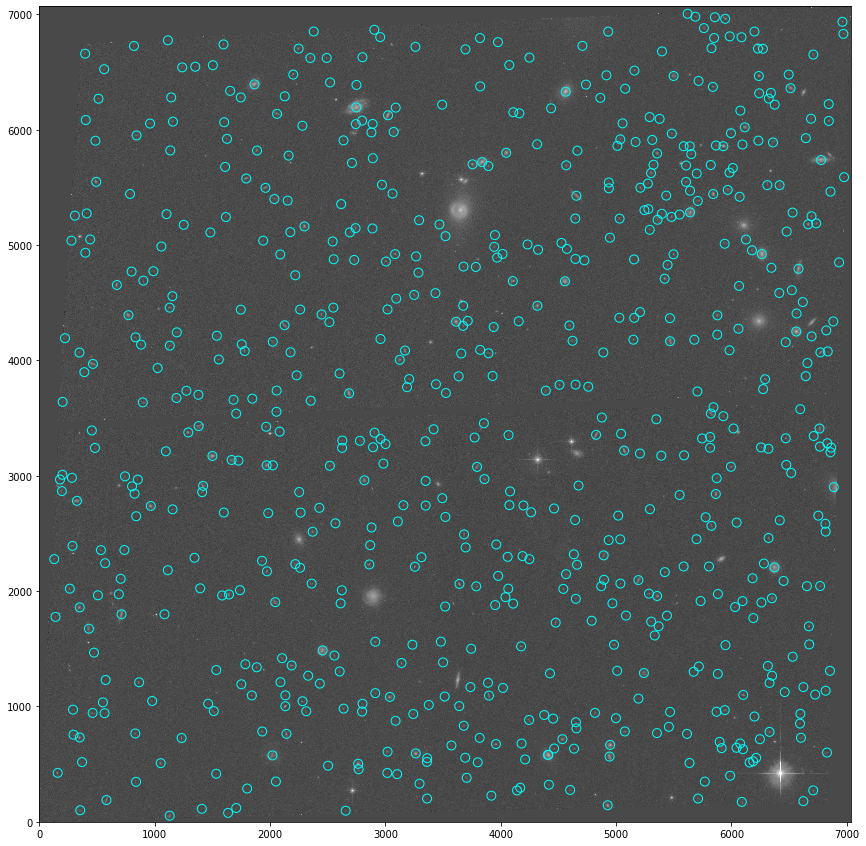

In [5]:
figure = plt.figure(figsize=(15,15))
plt.imshow(field_image.data, cmap='gray', norm=SymLogNorm(vmin=-0.13, vmax=20, linthresh=0.02), origin='lower')
plt.scatter(data.x, data.y, edgecolors="cyan", marker="o", facecolors='none', s=80)

In [6]:
def move_origin_in_arcsec_to(centre, x, y):
    new_x = []
    new_y = []
    for i in range(len(x)):
        new_x.append(x[i]-centre[1])
        new_y.append(y[i]-centre[0])

    return np.transpose(np.array([new_y, new_x]))

In [7]:
pixel_scale=0.03
centre_arc_sec = pixel_scale*centre
arcs_sec_x, arc_sec_y = data.x *pixel_scale, data.y*pixel_scale

arc_sec_centred = move_origin_in_arcsec_to(centre=centre_arc_sec, x=arcs_sec_x, y=arc_sec_y)

In [23]:
av_gamma1 =np.mean(data.gamma1)
av_gamma2 =np.mean(data.gamma2)
pa_av = 0.5*np.arctan2(av_gamma2,av_gamma1)
total_gamma_av=np.sqrt(av_gamma2**2+av_gamma1**2)

pa = 0.5*np.arctan2(data.gamma2,data.gamma1)
pa_new = pa-pa_av
total_gamma=np.sqrt(data.gamma2**2+data.gamma1**2)
gamma1_new= total_gamma*np.cos(2*pa_new)
gamma2_new= total_gamma*np.sin(2*pa_new)


print(np.mean(gamma2_new))

[-5.27249099e-01 -4.30758829e-02  5.00284326e-01  4.62957038e-01
  2.93582134e-01 -3.35887039e-01  3.56889293e-03  5.35158346e-02
 -1.87080359e-01  6.14380885e-02  1.35692618e-02  1.91582288e-01
  4.33095888e-01 -3.46399877e-01  3.34829639e-01 -1.66544728e-01
  1.36157417e-01  1.25482166e-01  3.78807540e-01  3.39691393e-02
 -7.96132926e-02 -4.65822722e-01  1.52510939e-01 -6.81878238e-02
  4.46606042e-02 -2.03835035e-02 -7.50362742e-02 -4.70574022e-02
 -3.75962221e-01 -3.45590258e-01 -4.23715167e-01 -3.05089616e-02
  3.08381358e-02 -1.30327710e-01 -1.62698376e-01  1.76826647e-01
 -1.99571681e-01  1.60975803e-01 -4.31227659e-04  2.72545559e-01
 -5.48162754e-02  2.87413935e-02  5.71035760e-02 -3.68964162e-01
  1.24201753e-01  4.81660777e-02  7.60352622e-03  2.91568765e-02
 -1.15085314e-01  3.33544815e-01  3.76185120e-01 -6.72607115e-01
  1.94952417e-01 -5.59696308e-02 -2.06148795e-01  2.47435569e-01
  2.62960349e-01 -1.36253769e-01 -1.77814315e-01 -3.56188949e-01
  3.43897489e-02  2.08548

In [8]:
weak_shear_grid = grids.GridIrregular(
        grid=arc_sec_centred
    )
weak_shear_field = vector_fields.VectorFieldIrregular(
        grid=weak_shear_grid,
        vectors=np.transpose(np.asarray([data.gamma2, data.gamma1]))
    )

weak_shear_inside_annulus = weak_shear_field.vectors_within_annulus(centre=(0,0), inner_radius=5, outer_radius=45)

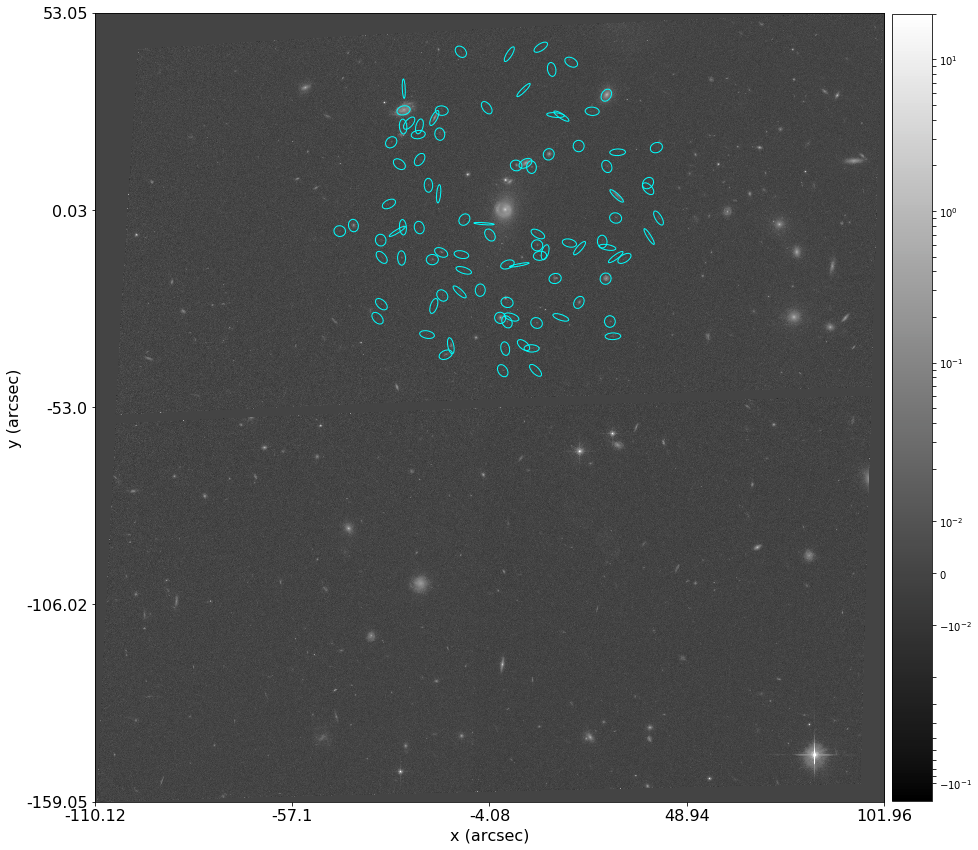

In [9]:
imaging = al.Array.from_fits(
    file_path=field_image_path,
    pixel_scales=pixel_scale,
    origin=(centre_a[0], -centre_a[1]),
)
image_2d = imaging.in_2d
plotter = aplt.Plotter(figure=aplt.Figure(figsize=(15,15)),cmap=aplt.ColorMap(cmap="gray", norm="symmetric_log", norm_min=-0.13, norm_max=20, linthresh=0.02, linscale=1.0),
                       grid_scatterer=aplt.GridScatterer(marker="+", colors='cyan', size=50))
aplt.Array(array=image_2d, plotter=plotter,patches=weak_shear_inside_annulus.elliptical_patches)

In [59]:
def ellipse_to_reg(catalogue_name, regName):
    catalogue = fits.open( catalogue_name )[1].data

    regionFile = open(regName, 'w')

    ellipticity = np.sqrt( catalogue.gamma1**2 +
                           catalogue.gamma2**2 )

    semi_major = (1 + ellipticity)*catalogue.gal_size
    semi_minor = (1 - ellipticity)*catalogue.gal_size
    angle = np.arctan2( catalogue.gamma2, catalogue.gamma1 )*180./np.pi/2.


    regionFile.write('# Region file format: DS9 version 4.1\n')
    regionFile.write('# Filename: dummy.fits\n')
    regionFile.write("global color=green dashlist=8 3 width=1 font='helvetica 10 normal roman' select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n")
    regionFile.write("physical\n")

    for iGal in range(len(catalogue.x)):

        regionFile.write('Ellipse(%0.4f,%0.4f,%0.4f,%0.4f,%0.4f)\n'
                    % (catalogue.x[iGal], catalogue.y[iGal],
                        semi_major[iGal], semi_minor[iGal], angle[iGal]))


In [60]:
ellipse_to_reg(catalogue_name=data_path, regName=f"/Users/dgmt59/Documents/Data/slacs_weak_lensing/{lens_no}_elipses.reg")



In [79]:
data_bad = pd.read_csv(f"/Users/dgmt59/Documents/Data/slacs_weak_lensing/{lens_no}_to_remove.txt",
                       delimiter=',', header=None, skiprows=3,
                       names=["x", "y", "major", "minor", "angle"])
data_bad["x"] = data_bad["x"].str.strip('ellipses(').astype(float)
data_bad["angle"] = data_bad["angle"].str.strip(')').astype(float)

In [80]:
Shears=data

for i in range(len(data.x)):
    for j in range(len(data_bad["x"])):   #go through the star list
        if np.round(data.x[i],4)==data_bad["x"][j] and np.round(data.y[i],4)==data_bad["y"][j]:
            Shears['clean'][i]=1

print("done")
Shears_remove=Shears[Shears['clean']==0]

fits.writeto(f"/Users/dgmt59/Documents/Data/slacs_weak_lensing/{lens_no}_F814W_drz_sci_clean.shears_clean",
             Shears_remove, overwrite=True, output_verify='ignore' )

done


In [81]:
data_path_clean = f"/Users/dgmt59/Documents/Data/slacs_weak_lensing/{lens_no}_F814W_drz_sci_clean.shears_clean"

weak_shear_clean = fits.open(data_path_clean)
data_clean = weak_shear_clean[1].data

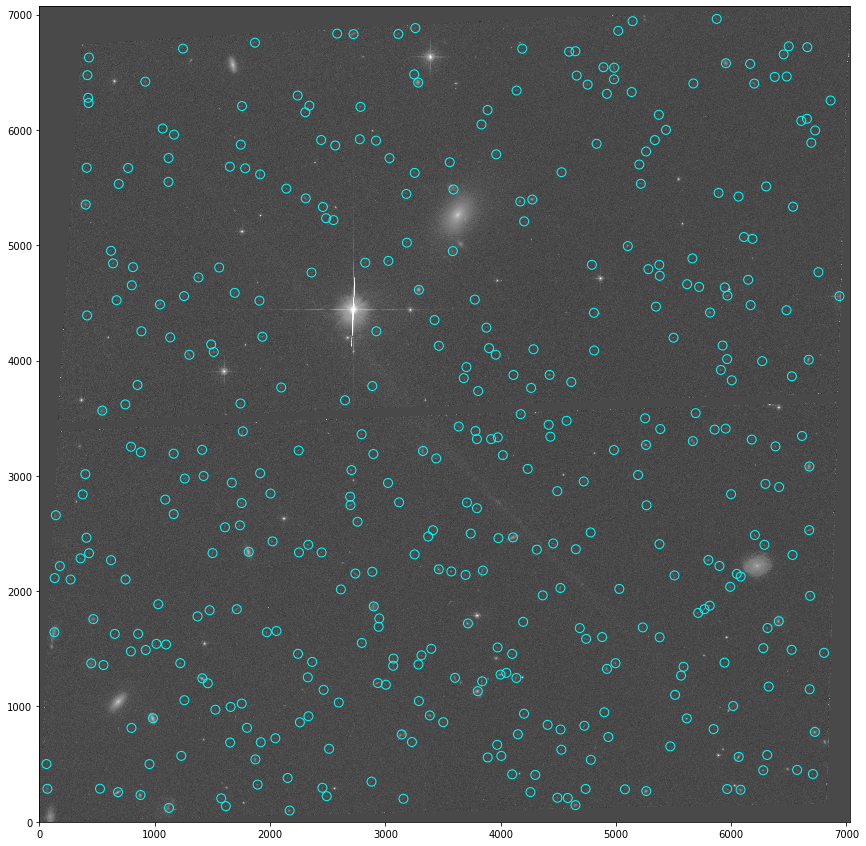

In [82]:
figure = plt.figure(figsize=(15,15))
plt.imshow(field_image.data, cmap='gray', norm=SymLogNorm(vmin=-0.13, vmax=20, linthresh=0.02), origin='lower')
plt.scatter(data_clean.x, data_clean.y, edgecolors="cyan", marker="o", facecolors='none', s=80)
